In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import itertools as it
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torch.nn.functional as F

import os
import json

In [21]:
class CustomLoss:
    def __init__(self,):
        pass

In [22]:
class FaultDataset(Dataset):
    def __init__(self, data, transform, data_path):
        self.data = data
        self.transform = transform
        self.data_path = data_path

    def __getitem__(self, index):
        record = self.data[index]
        seis = Image.open(os.path.join(self.data_path, "seis", record["data"]))
        if self.transform is not None:
            seis = self.transform(seis)
        label = Image.open(os.path.join(self.data_path, "fault", record["label"]))
        label = transforms.ToTensor()(label)
        return seis, label

    def __len__(self):
        return len(self.data)

In [23]:
DATA_PATH = os.path.join("data", "256Window")
train_path = os.path.join(DATA_PATH, "train")

with open(os.path.join(train_path, "metadata.json"), "r") as file:
    train_list = json.load(file)

preprocess = transforms.Compose([transforms.ToTensor()])
train_dataset = FaultDataset(train_list, preprocess, train_path)


In [56]:
weights = torch.tensor([[0.5, 0.5, 0.5],
                        [0.5, 1., 0.5],
                        [0.5, 0.5, 0.5]])

In [79]:
def weight_function_1(distance: float):
    return 1 / (distance + 1)

In [119]:
def fill_weights(y_true: torch.Tensor,
                 row_index: int, 
                 column_index: int, 
                 distance: int, 
                 weight_function: callable):
    max_x, max_y = y_true[0].shape
    max_x, max_y = max_x-1, max_y-1
    for x, y in it.product(range(distance*-1, distance+1), repeat=2):
        if (row_index + x) < 0 or (column_index + y) < 0:
            continue
        if (row_index + x) > max_x or (column_index + y) > max_y:
            continue
        new_value = weight_function(distance=(abs(x) + abs(y)))
        if y_true[0, row_index + x, column_index + y] < new_value:
            y_true[0, row_index + x, column_index + y] = weight_function(distance=(abs(x) + abs(y)))
    return y_true

In [107]:
def get_distance_weight(y_true: torch.Tensor,
                        treshold: float = 0.8,
                        distance: int = 2):
    y_true = (y_true > treshold).type(torch.float32)
    for row_index, row in enumerate(y_true[0]):
        for column_index, value in enumerate(row):
            if value == 1:
                y_true = fill_weights(y_true, row_index, column_index, distance, weight_function_1)
    return y_true

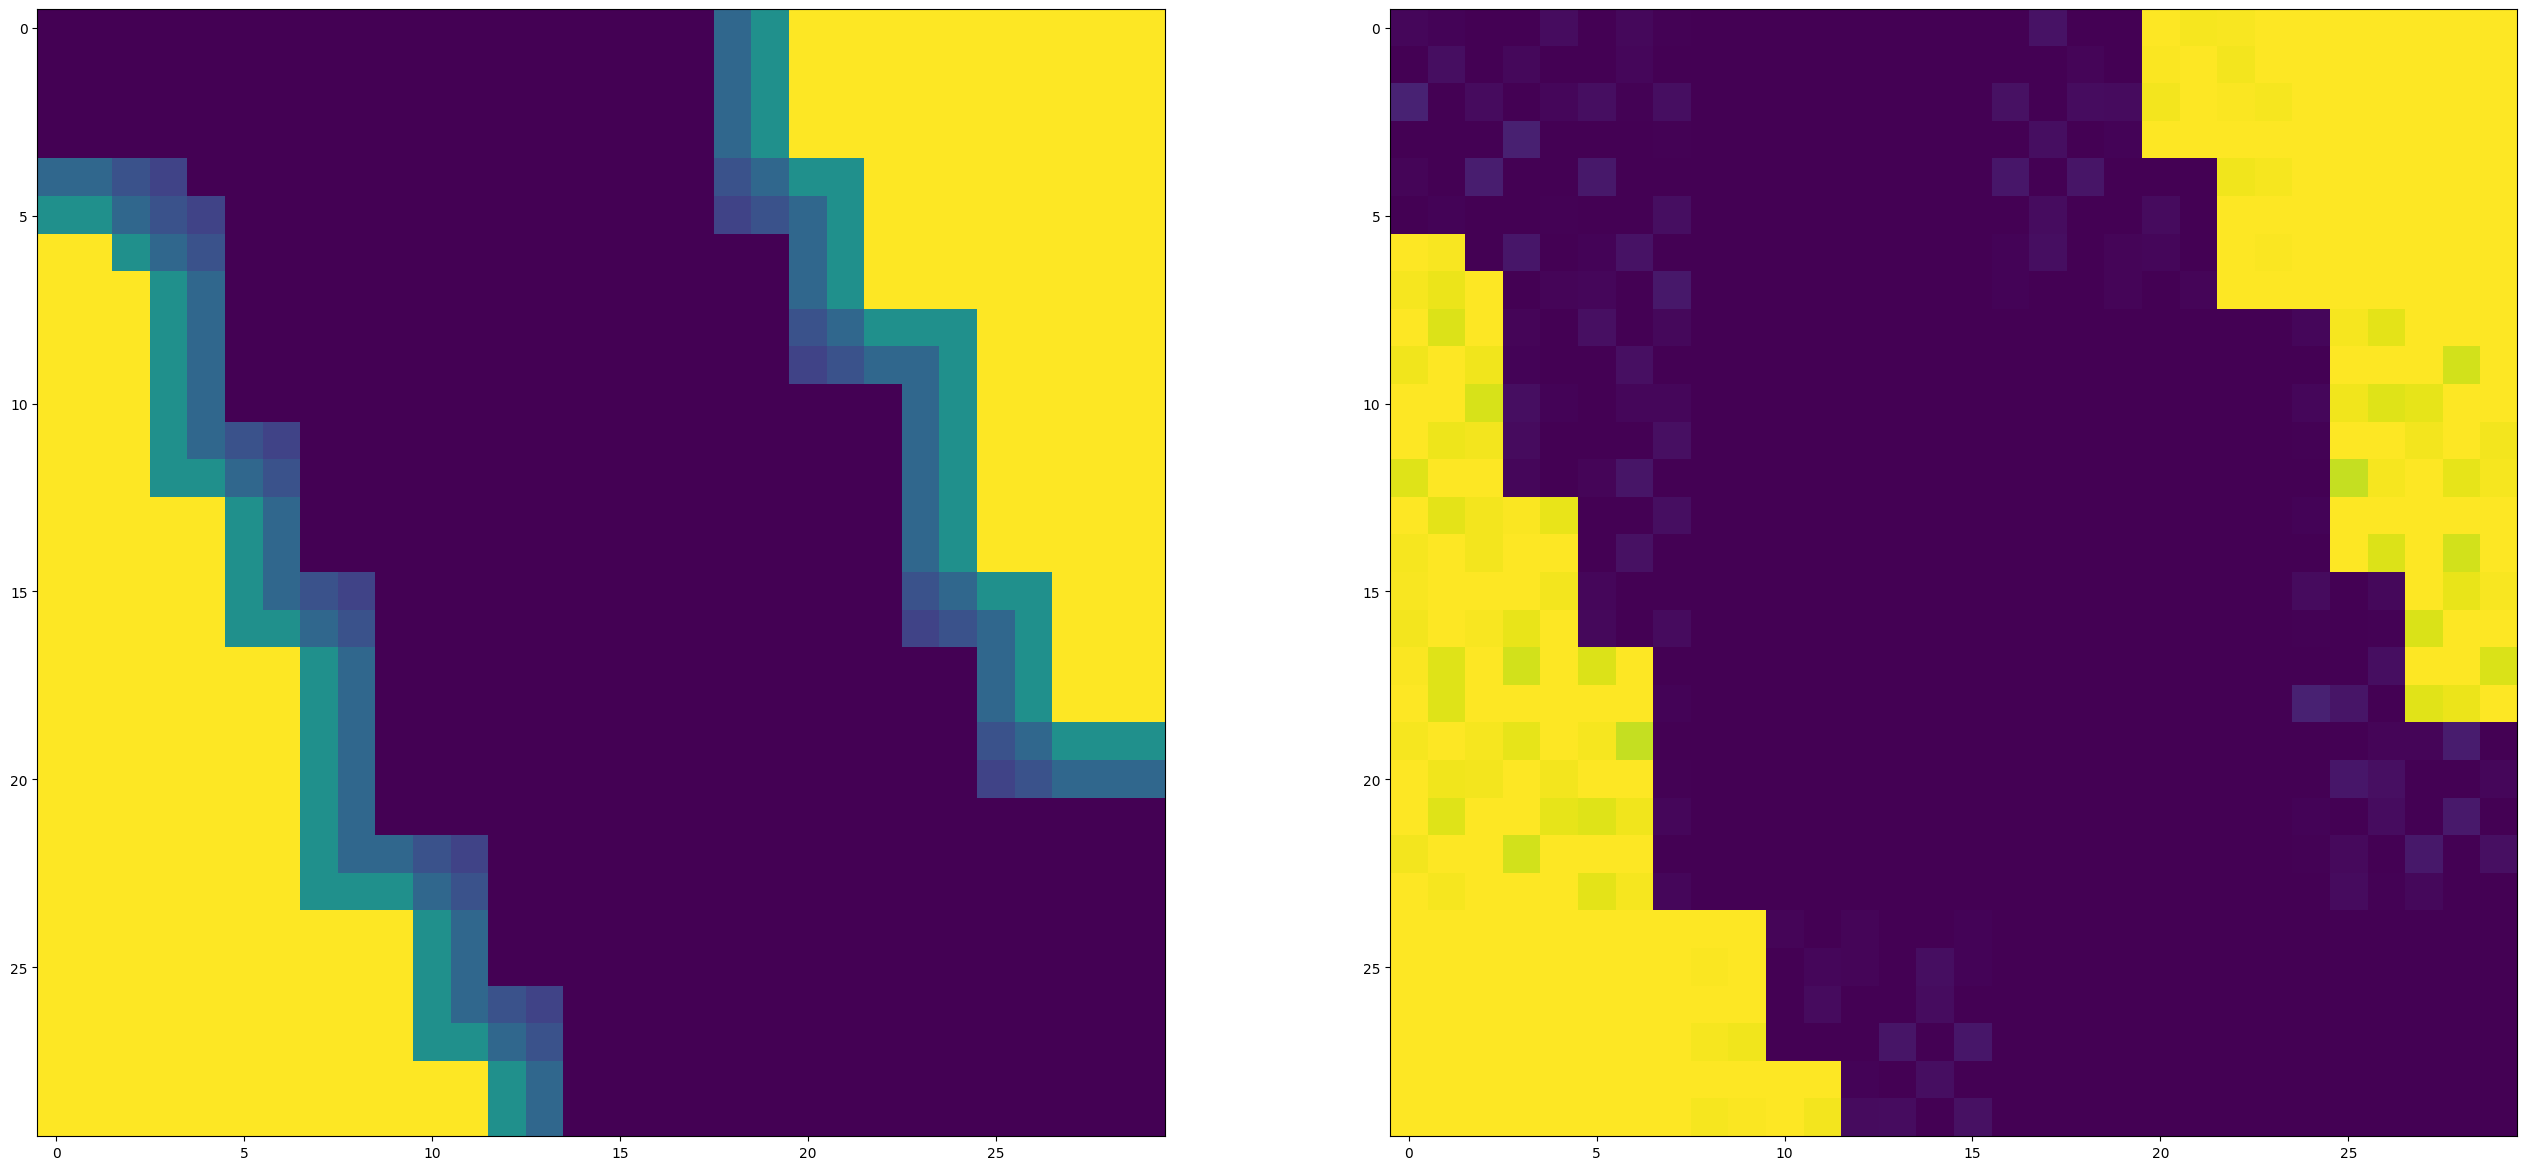

In [120]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(32, 18))
ax1.imshow(get_distance_weight(train_dataset[0][1][:30, :30, :30])[0])
ax2.imshow(train_dataset[0][1][:30, :30, :30][0])

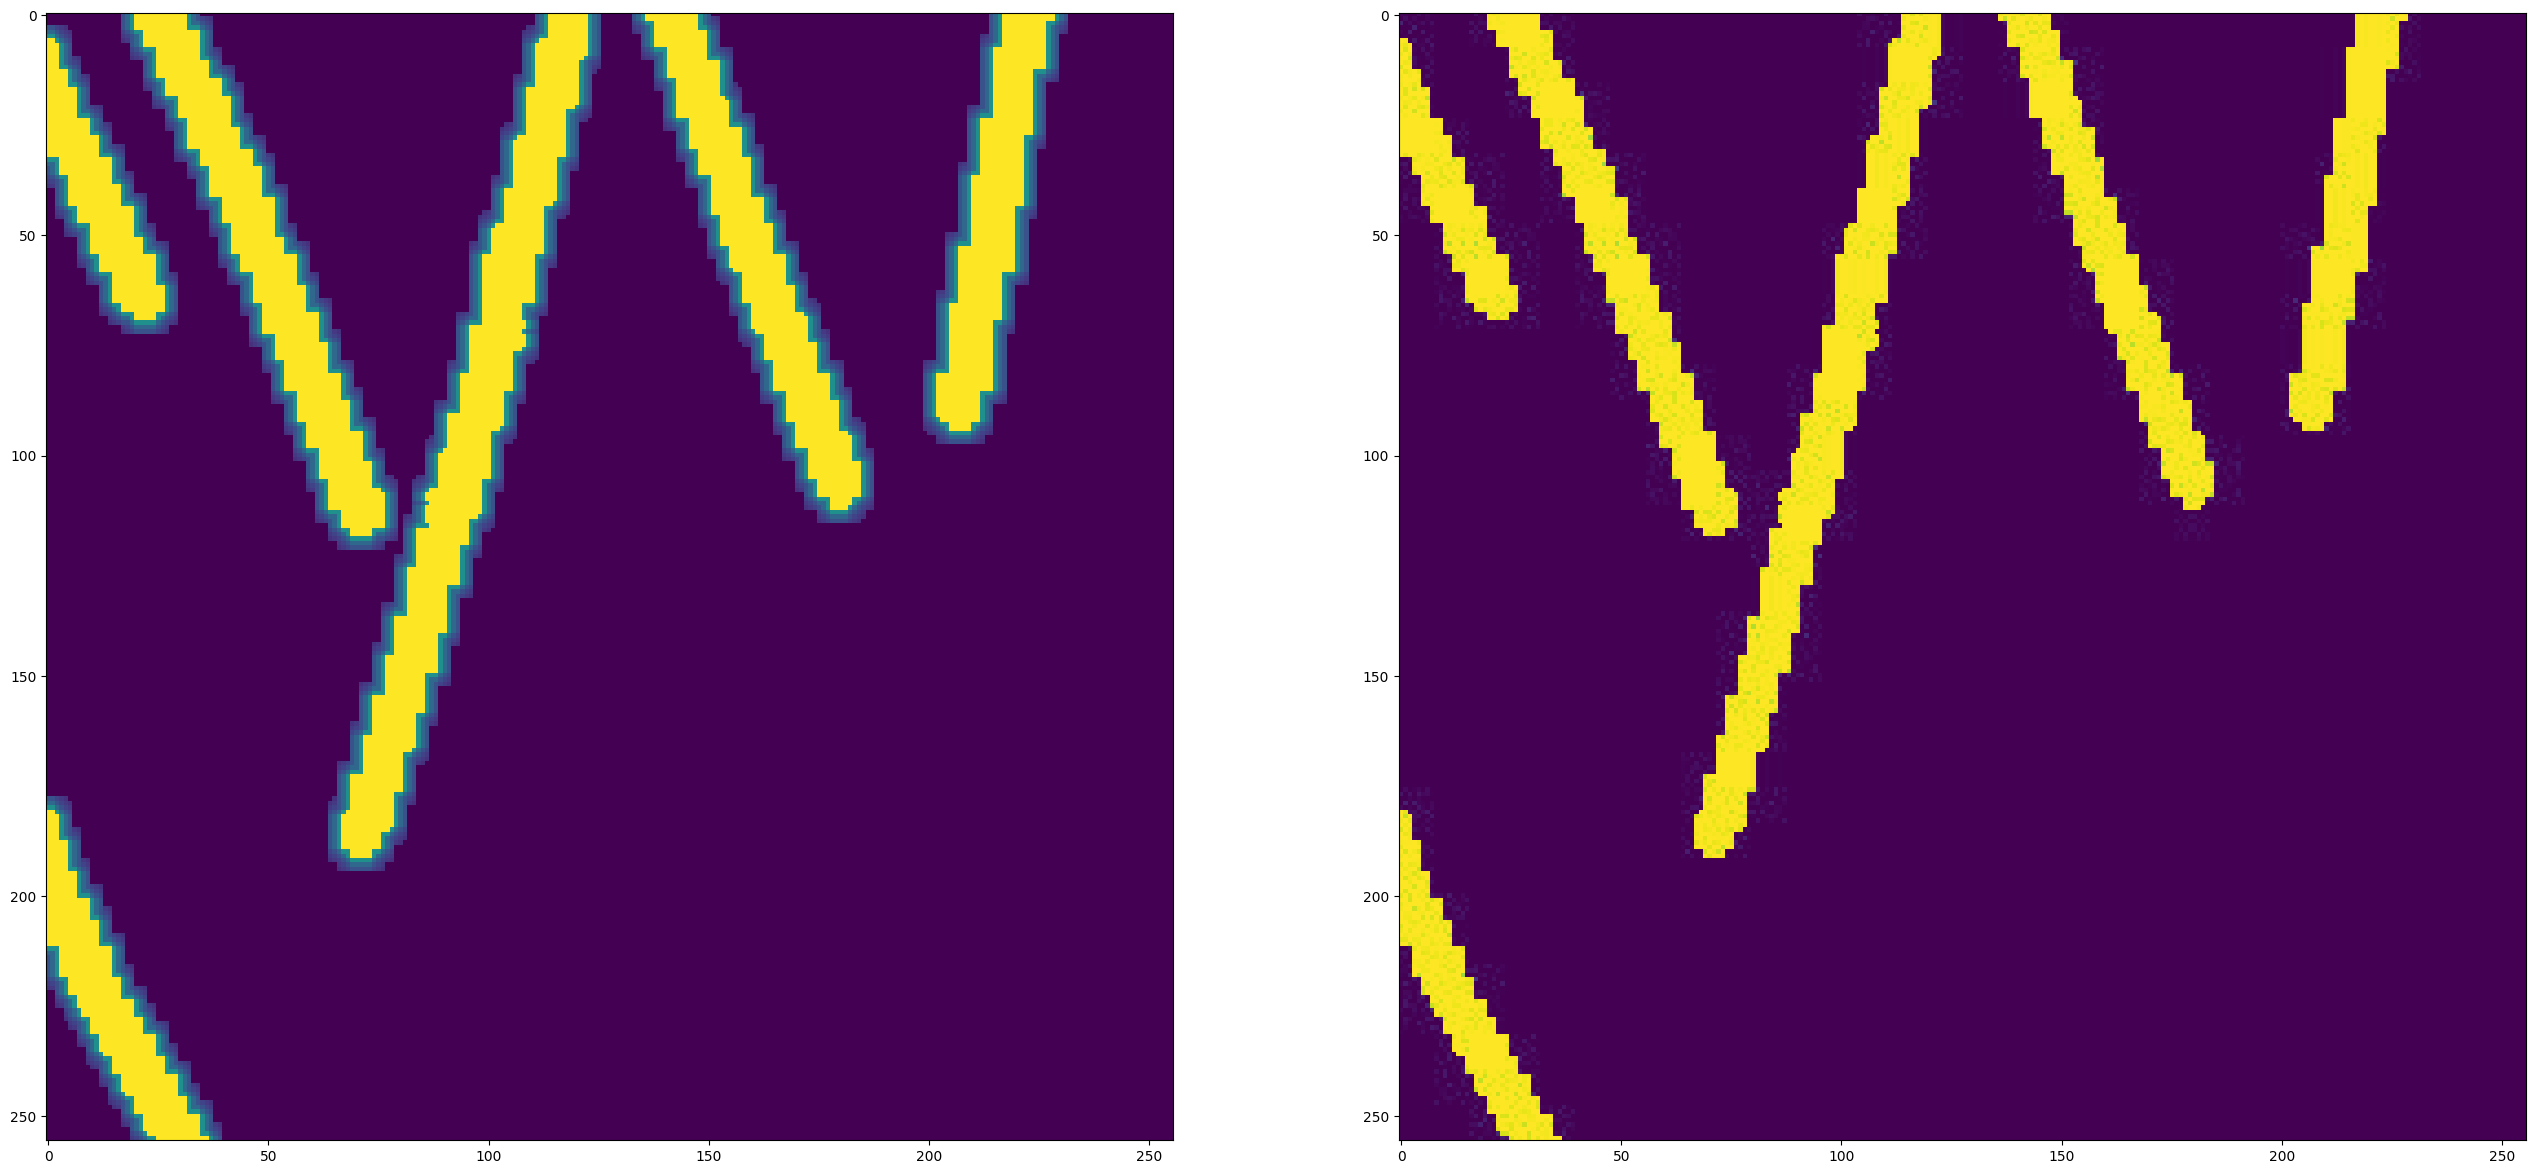

In [128]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(32, 18))
ax1.imshow(get_distance_weight(train_dataset[0][1], distance=3)[0])
ax2.imshow(train_dataset[0][1][0])

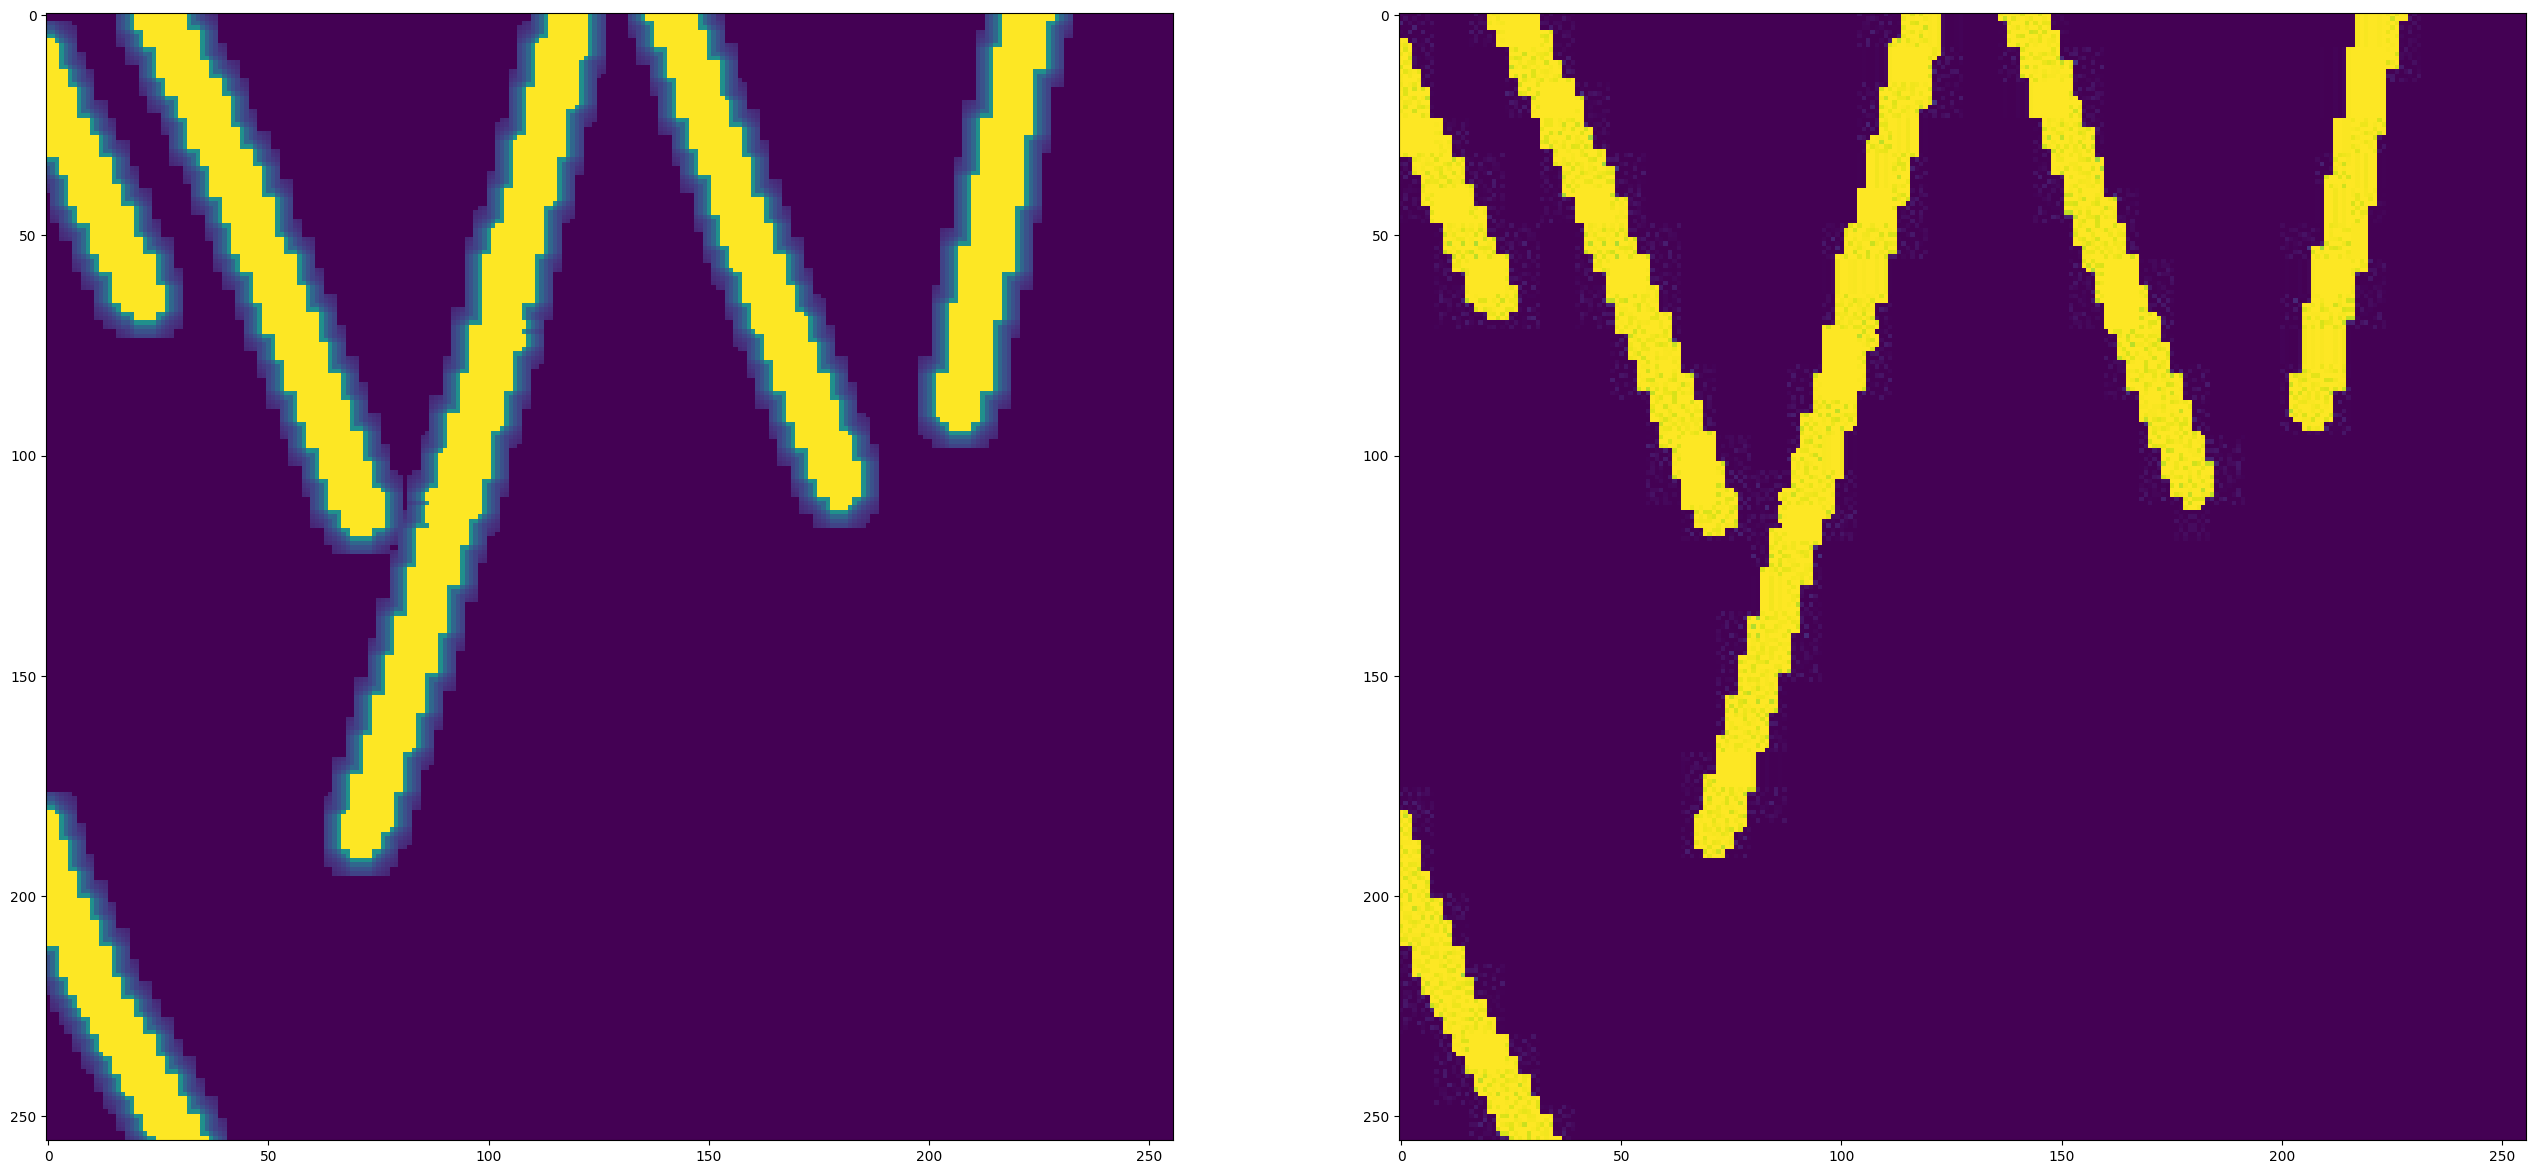

In [130]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(32, 18))
ax1.imshow(get_distance_weight(train_dataset[0][1], distance=4)[0])
ax2.imshow(train_dataset[0][1][0])